<a href="https://colab.research.google.com/github/forumb94/energypricecode/blob/main/maincode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
#!pip install plotly

# tensorflow-addons version depends on the tensorflow and python version of the system,
# you can find the compatibility in this link

# https://stackoverflow.com/questions/61380552/unable-to-import-tensorflow-addons
#!pip install tensorflow-addons
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
#!pip install --upgrade tensorflow-addons
#!pip install tensorflow-addons==0.21.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io

import numpy as np
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
#import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [2]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('final_merged_data_V1.csv')

Saving final_merged_data_V1.csv to final_merged_data_V1.csv


In [3]:
# Read the dataset
df = pd.read_csv(io.BytesIO(uploaded['final_merged_data_V1.csv']))

In [4]:
# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')

# Fill missing values for numeric columns using forward fill, then backward fill as backup
numeric_cols = df.select_dtypes(include=["number"]).columns
df[numeric_cols] = df[numeric_cols].ffill().bfill()

# Drop unnecessary columns
#df.drop(columns=['Local Date', 'Hour Number'], inplace=True, errors='ignore')

# Display dataset info
print(df.info())

# Display first few rows
print(df.head())

# Generate summary statistics
summary_stats = df.describe().T
missing_values = df.isnull().sum()
unique_counts = df.nunique()

# Display key statistics
print("\nSummary Statistics:")
print(summary_stats)

print("\nMissing Values Per Column:")
print(missing_values[missing_values > 0])

print("\nUnique Value Counts for Categorical Columns:")
print(unique_counts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35081 entries, 0 to 35080
Data columns (total 58 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Local Date                                            35081 non-null  object        
 1   Hour Number                                           35081 non-null  int64         
 2   Time                                                  0 non-null      datetime64[ns]
 3   Total Generation (MW)                                 35081 non-null  float64       
 4   Dual Fuel Generation (MW)                             35081 non-null  float64       
 5   Hydro Generation (MW)                                 35081 non-null  float64       
 6   Natural Gas Generation (MW)                           35081 non-null  float64       
 7   Nuclear Generation (MW)                               35081 non-null  float6

In [5]:
print(df.columns)

Index(['Local Date', 'Hour Number', 'Time', 'Total Generation (MW)',
       'Dual Fuel Generation (MW)', 'Hydro Generation (MW)',
       'Natural Gas Generation (MW)', 'Nuclear Generation (MW)',
       'Other Fossil Fuels Generation (MW)',
       'Other Renewables Generation (MW)', 'Wind Generation (MW)',
       'DAMP A - West', 'DAMP B - Genessee', 'DAMP C - Central',
       'DAMP D - North', 'DAMP E - Mohawk Valley', 'DAMP F - Capital',
       'DAMP G - Hudson Valley', 'DAMP H - Millwood', 'DAMP I - Dunwoodie',
       'DAMP J - New York City', 'DAMP K - Long Island',
       'F - Capital Actual Load (MW)', 'C - Central Actual Load (MW)',
       'I - Dunwoodie Actual Load (MW)', 'B - Genessee Actual Load (MW)',
       'G - Hudson Valley Actual Load (MW)',
       'K - Long Island Actual Load (MW)',
       'E - Mohawk Valley Actual Load (MW)', 'H - Millwood Actual Load (MW)',
       'J - New York City Actual Load (MW)', 'D - North Actual Load (MW)',
       'A - West Actual Load (MW)', 'N

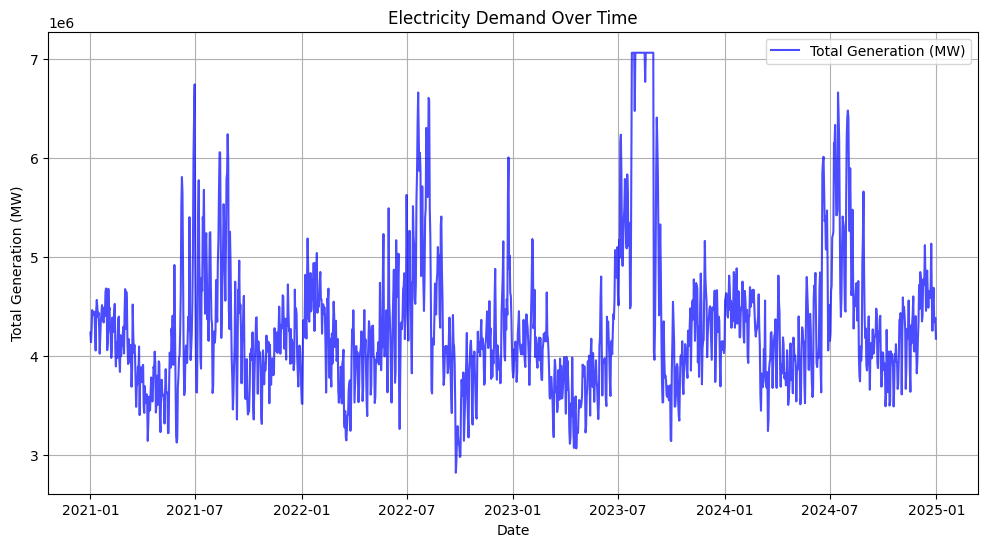

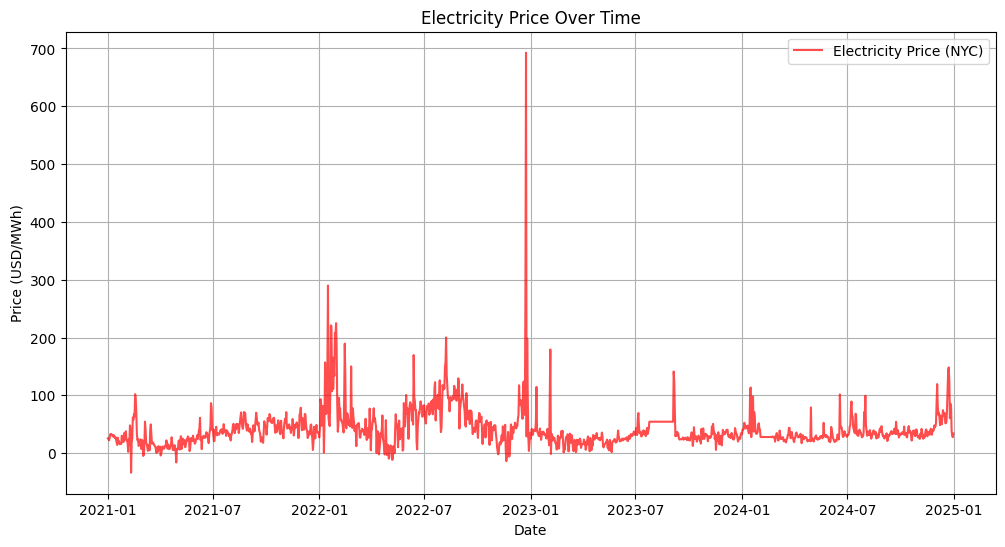

In [11]:
# Convert date column to datetime format for time-series analysis
df['Local Date'] = pd.to_datetime(df['Local Date'])

# Aggregate data by day for visualization
daily_demand = df.groupby('Local Date')['Total Generation (MW)'].sum()
daily_price = df.groupby('Local Date')['Real Time J - New York City'].mean()  # Using NYC as a representative price

# Plot electricity demand over time
plt.figure(figsize=(12, 6))
plt.plot(daily_demand, label='Total Generation (MW)', color='blue', alpha=0.7)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Generation (MW)')
plt.legend()
plt.grid(True)
plt.show()

# Plot electricity price over time
plt.figure(figsize=(12, 6))
plt.plot(daily_price, label='Electricity Price (NYC)', color='red', alpha=0.7)
plt.title('Electricity Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD/MWh)')
plt.legend()
plt.grid(True)
plt.show()


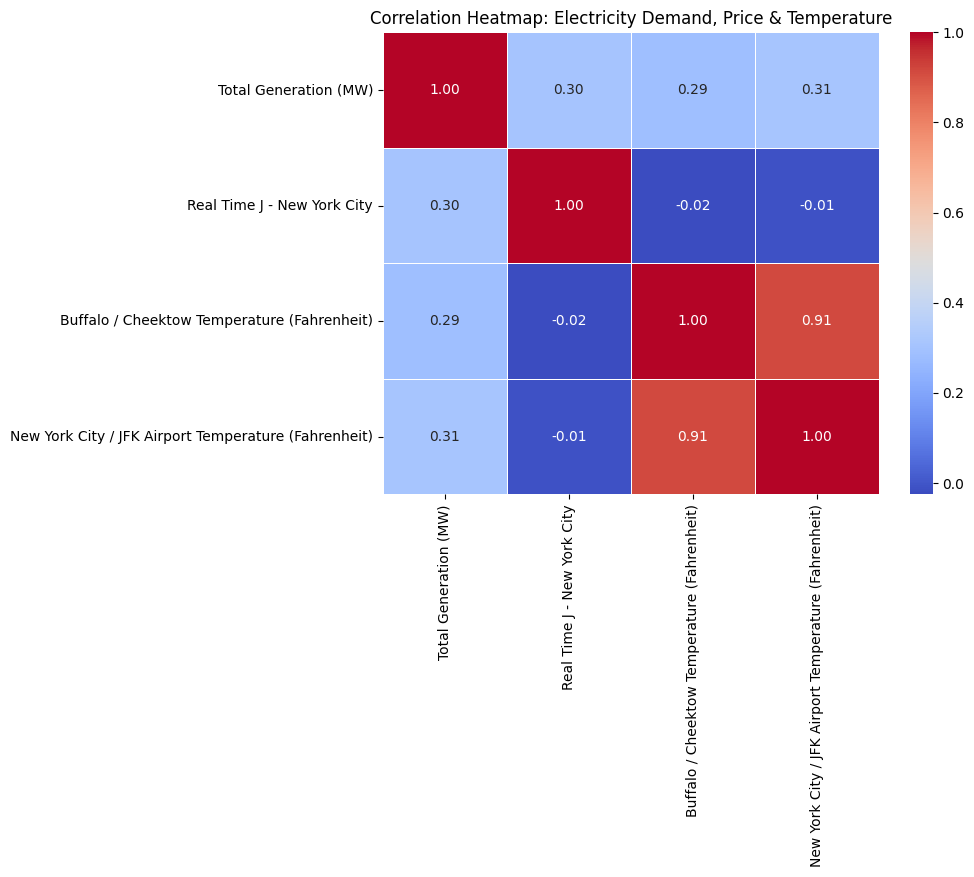

In [12]:
# Compute correlation matrix for relevant numerical variables
relevant_columns = ['Total Generation (MW)', 'Real Time J - New York City',
                    'Buffalo / Cheektow Temperature (Fahrenheit)',
                    'New York City / JFK Airport Temperature (Fahrenheit)']
correlation_matrix = df[relevant_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Electricity Demand, Price & Temperature")
plt.show()


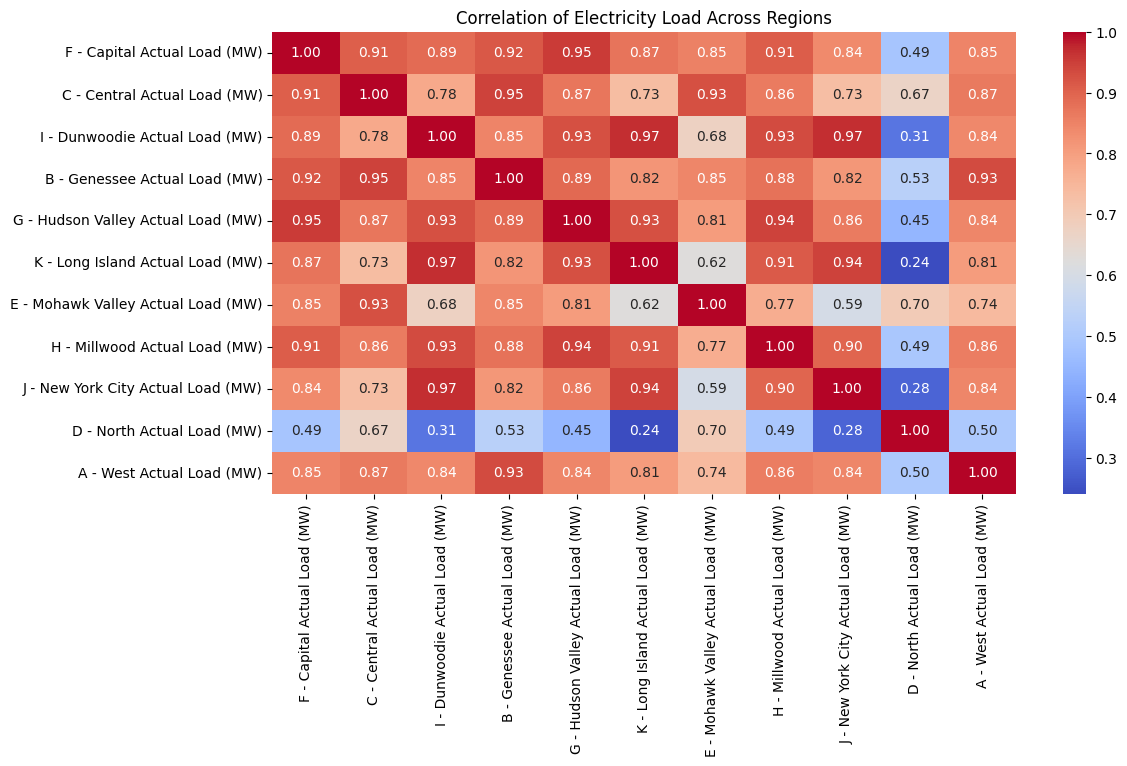

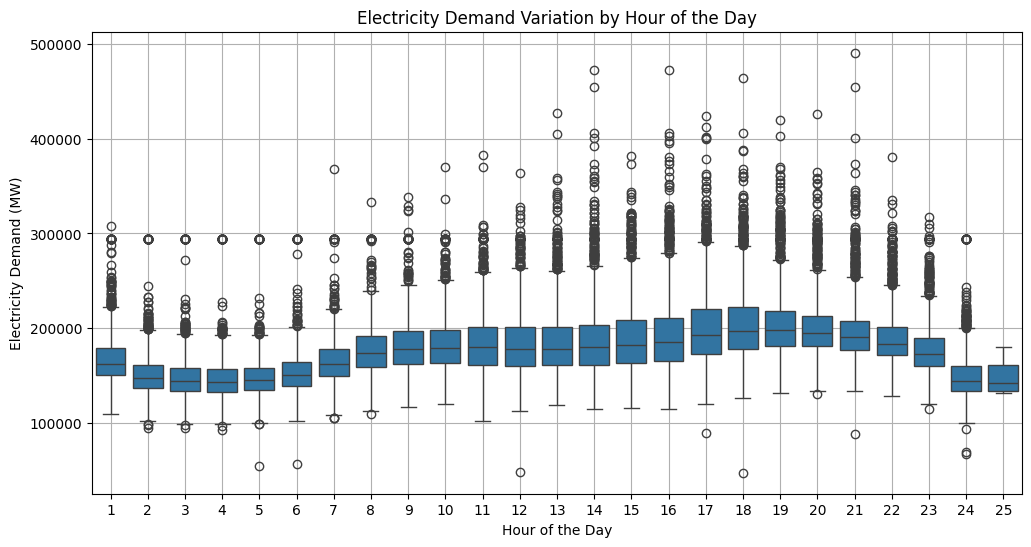

In [13]:
# Regional Load Analysis (Heatmap)

# Identify regional load columns based on column names containing "Actual Load"
regional_load_columns = [col for col in df.columns if "Actual Load" in col]

# Check if there are regional load columns available
if regional_load_columns:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df[regional_load_columns].corr(), cmap="coolwarm", annot=True, fmt=".2f")
    plt.title("Correlation of Electricity Load Across Regions")
    plt.show()
else:
    print("No regional load data found in the dataset.")

# Peak Demand Hours (Boxplot)

# Check if 'Hour Number' column exists before proceeding
if 'Hour Number' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['Hour Number'], y=df['Total Generation (MW)'])
    plt.xlabel("Hour of the Day")
    plt.ylabel("Electricity Demand (MW)")
    plt.title("Electricity Demand Variation by Hour of the Day")
    plt.grid(True)
    plt.show()
else:
    print("Hour Number column not found in the dataset.")


## Regional Load Correlation (Heatmap):

Shows the correlation between different regions' electricity load.
Strong correlations suggest regions have similar demand patterns, possibly due to shared weather conditions or economic activity.

## Peak Demand Hours (Boxplot):

Electricity demand fluctuates throughout the day.
Peak hours likely occur in the afternoon and evening when residential and commercial activity is high.
Lower demand periods are typically observed during late night/early morning hours.

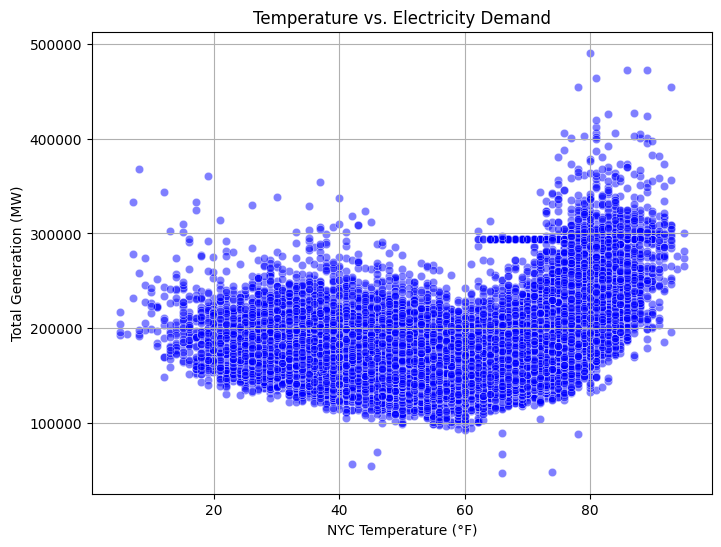

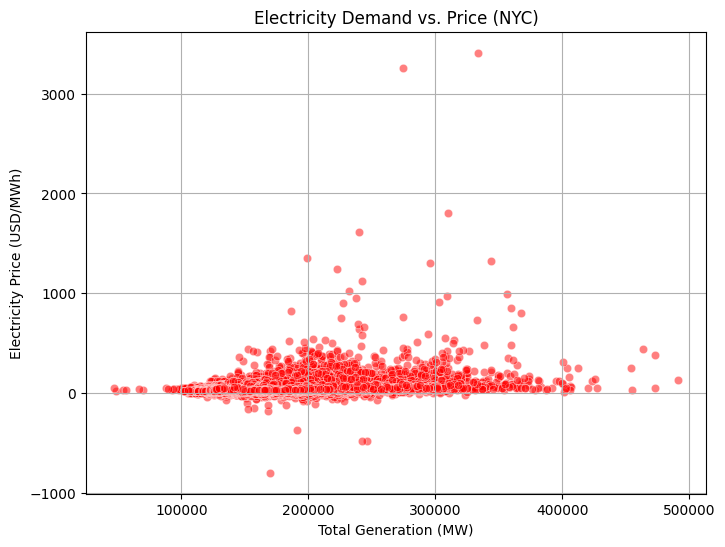

In [14]:
# Scatter plot: Temperature vs. Electricity Demand
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['New York City / JFK Airport Temperature (Fahrenheit)'],
                y=df['Total Generation (MW)'], alpha=0.5, color='blue')
plt.title("Temperature vs. Electricity Demand")
plt.xlabel("NYC Temperature (°F)")
plt.ylabel("Total Generation (MW)")
plt.grid(True)
plt.show()

# Scatter plot: Electricity Demand vs. Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Total Generation (MW)'],
                y=df['Real Time J - New York City'], alpha=0.5, color='red')
plt.title("Electricity Demand vs. Price (NYC)")
plt.xlabel("Total Generation (MW)")
plt.ylabel("Electricity Price (USD/MWh)")
plt.grid(True)
plt.show()


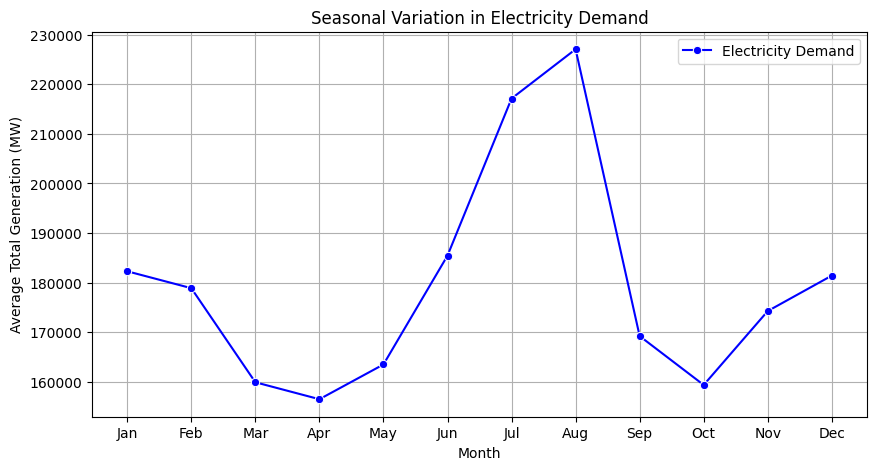

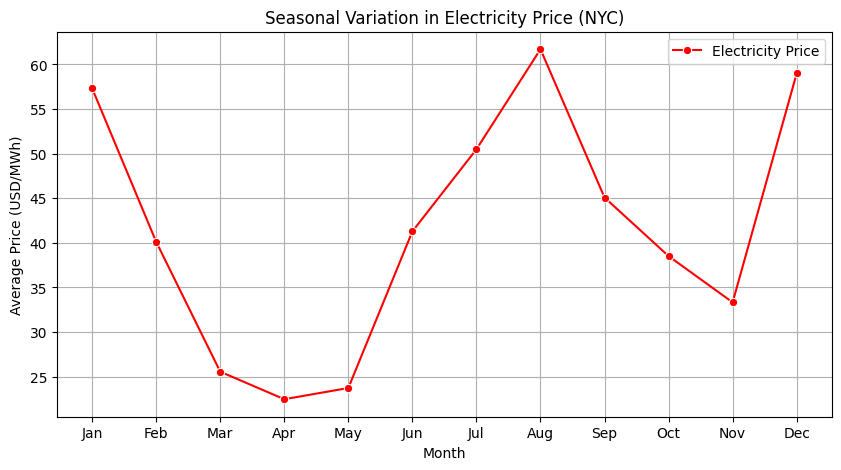

In [15]:
# Extract month from date for seasonal analysis
df['Month'] = df['Local Date'].dt.month

# Aggregate data by month
monthly_demand = df.groupby('Month')['Total Generation (MW)'].mean()
monthly_price = df.groupby('Month')['Real Time J - New York City'].mean()

# Plot seasonal electricity demand trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_demand.index, y=monthly_demand.values, marker='o', color='blue', label="Electricity Demand")
plt.title("Seasonal Variation in Electricity Demand")
plt.xlabel("Month")
plt.ylabel("Average Total Generation (MW)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.show()

# Plot seasonal electricity price trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_price.index, y=monthly_price.values, marker='o', color='red', label="Electricity Price")
plt.title("Seasonal Variation in Electricity Price (NYC)")
plt.xlabel("Month")
plt.ylabel("Average Price (USD/MWh)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-16-0fdeb44c336f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Month'], y=df['Real Time J - New York City'], palette="Reds")


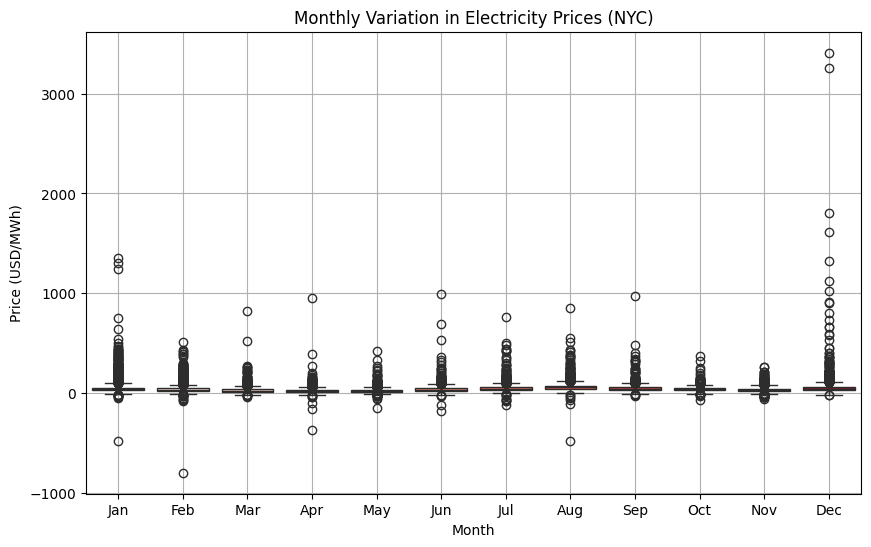

<ipython-input-16-0fdeb44c336f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Month'], y=df['Total Generation (MW)'], palette="Blues")


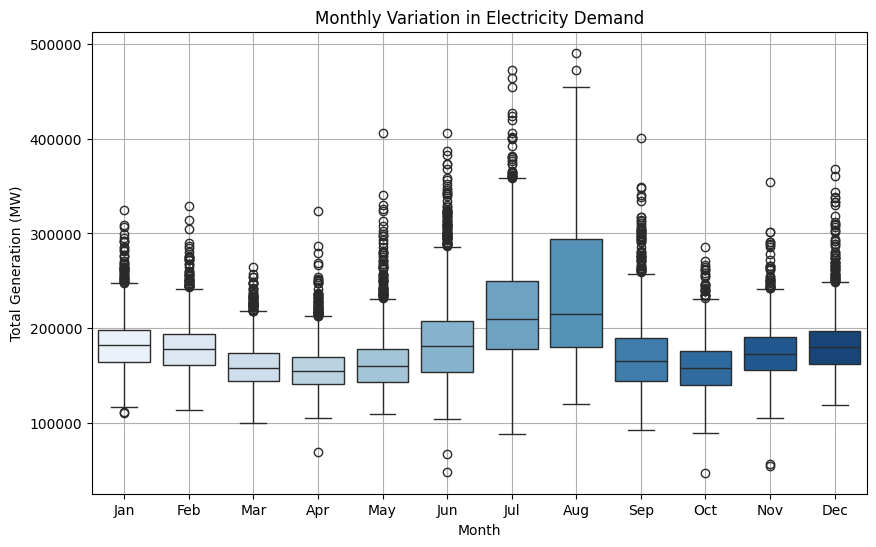

In [16]:
# 2. Boxplot of Electricity Prices by Month
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Month'], y=df['Real Time J - New York City'], palette="Reds")
plt.title("Monthly Variation in Electricity Prices (NYC)")
plt.xlabel("Month")
plt.ylabel("Price (USD/MWh)")
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# 3. Boxplot of Electricity Demand by Month
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Month'], y=df['Total Generation (MW)'], palette="Blues")
plt.title("Monthly Variation in Electricity Demand")
plt.xlabel("Month")
plt.ylabel("Total Generation (MW)")
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

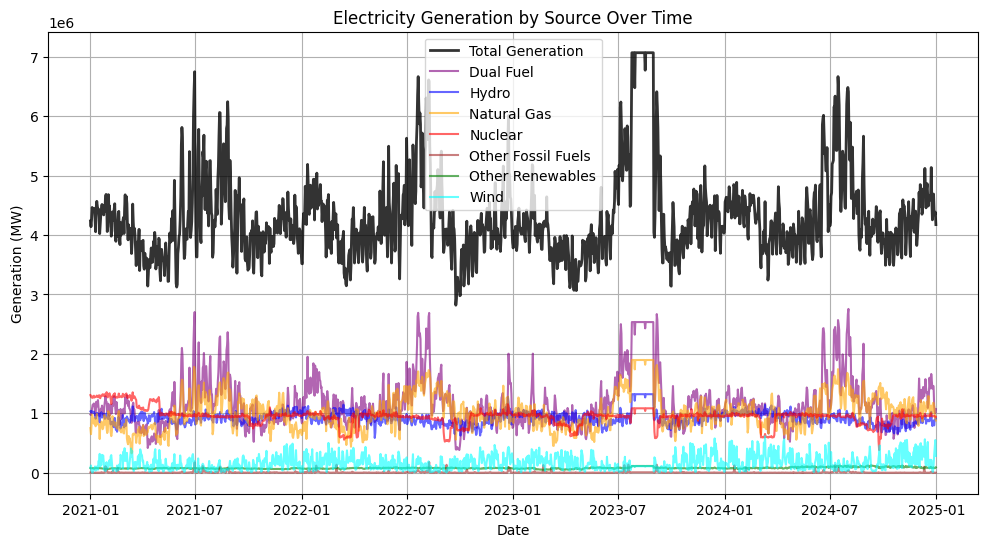

In [17]:
# Time-Series Analysis of Individual Generation Sources vs Total Generation

# Aggregating data by date for each generation type
daily_dual_fuel = df.groupby('Local Date')['Dual Fuel Generation (MW)'].sum()
daily_hydro = df.groupby('Local Date')['Hydro Generation (MW)'].sum()
daily_natural_gas = df.groupby('Local Date')['Natural Gas Generation (MW)'].sum()
daily_nuclear = df.groupby('Local Date')['Nuclear Generation (MW)'].sum()
daily_other_fossil = df.groupby('Local Date')['Other Fossil Fuels Generation (MW)'].sum()
daily_other_renewables = df.groupby('Local Date')['Other Renewables Generation (MW)'].sum()
daily_wind = df.groupby('Local Date')['Wind Generation (MW)'].sum()
daily_total = df.groupby('Local Date')['Total Generation (MW)'].sum()

# Plot all individual generation sources against total generation
plt.figure(figsize=(12, 6))
plt.plot(daily_total, label="Total Generation", color='black', linewidth=2, alpha=0.8)
plt.plot(daily_dual_fuel, label="Dual Fuel", color='purple', alpha=0.6)
plt.plot(daily_hydro, label="Hydro", color='blue', alpha=0.6)
plt.plot(daily_natural_gas, label="Natural Gas", color='orange', alpha=0.6)
plt.plot(daily_nuclear, label="Nuclear", color='red', alpha=0.6)
plt.plot(daily_other_fossil, label="Other Fossil Fuels", color='brown', alpha=0.6)
plt.plot(daily_other_renewables, label="Other Renewables", color='green', alpha=0.6)
plt.plot(daily_wind, label="Wind", color='cyan', alpha=0.6)

# Chart details
plt.title("Electricity Generation by Source Over Time")
plt.xlabel("Date")
plt.ylabel("Generation (MW)")
plt.legend()
plt.grid(True)
plt.show()


## Electricity Generation by Source Over Time

Total Generation (black line) shows significant fluctuations over time, driven by seasonal demand changes.

Natural Gas (orange) and Nuclear (red) are dominant sources, contributing consistently to electricity generation.

Hydro (blue) and Wind (cyan) show more seasonal variations, likely influenced by weather conditions.

Other Renewables (green) show a slow but steady increase, reflecting the growth in sustainable energy adoption.

Dual Fuel (purple) and Other Fossil Fuels (brown) contribute sporadically, possibly used as backup sources.

## Key Insights:

Natural Gas & Nuclear remain the backbone of electricity generation.

Renewable sources (Wind, Hydro, and Other Renewables) are growing but remain a smaller fraction of total generation.

Seasonal variability impacts Hydro and Wind generation.

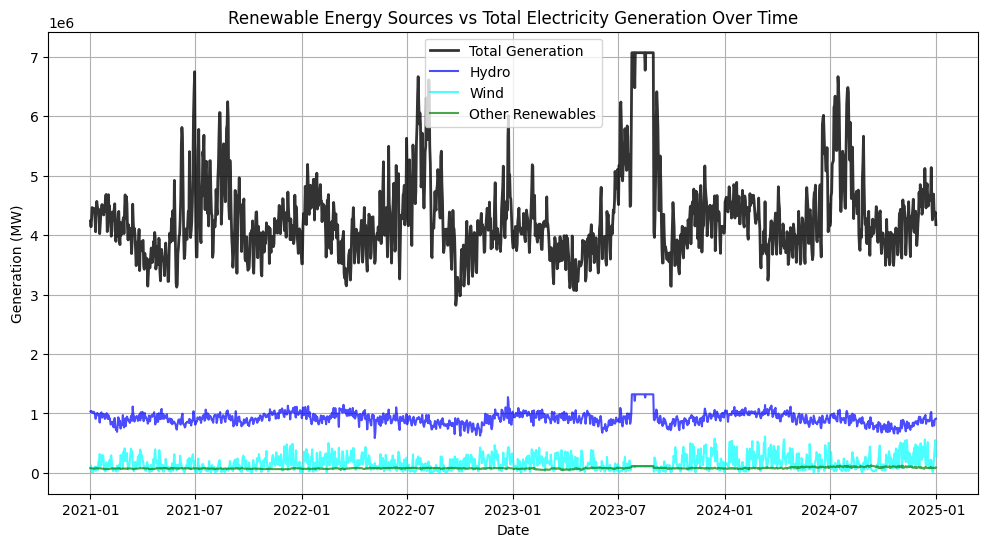

In [18]:
# Time-Series Analysis of Renewable Sources vs Total Generation

plt.figure(figsize=(12, 6))

# Plot total generation
plt.plot(daily_total, label="Total Generation", color='black', linewidth=2, alpha=0.8)

# Plot renewable energy sources
plt.plot(daily_hydro, label="Hydro", color='blue', alpha=0.7)
plt.plot(daily_wind, label="Wind", color='cyan', alpha=0.7)
plt.plot(daily_other_renewables, label="Other Renewables", color='green', alpha=0.7)

# Chart details
plt.title("Renewable Energy Sources vs Total Electricity Generation Over Time")
plt.xlabel("Date")
plt.ylabel("Generation (MW)")
plt.legend()
plt.grid(True)
plt.show()


## Renewable Energy Sources vs Total Generation

Hydro (blue) is the most significant renewable source, showing periodic fluctuations likely due to seasonal water availability.

Wind (cyan) follows a more irregular pattern, indicating dependence on weather conditions.

Other Renewables (green) show a slow but steady rise, reflecting increased adoption of alternative energy sources.

Total Generation (black) remains consistently higher, emphasizing the continued reliance on non-renewable energy.

## Key Takeaways:

Hydro and Wind contribute the most among renewables but remain variable.

Other Renewables are growing steadily.

Renewable sources still make up a relatively small portion of total generation.

Most peak demand days occur in summer (June - August), aligning with high cooling needs.

Extreme price surges are seen during winter (December - January), likely due to heating demands and market volatility.

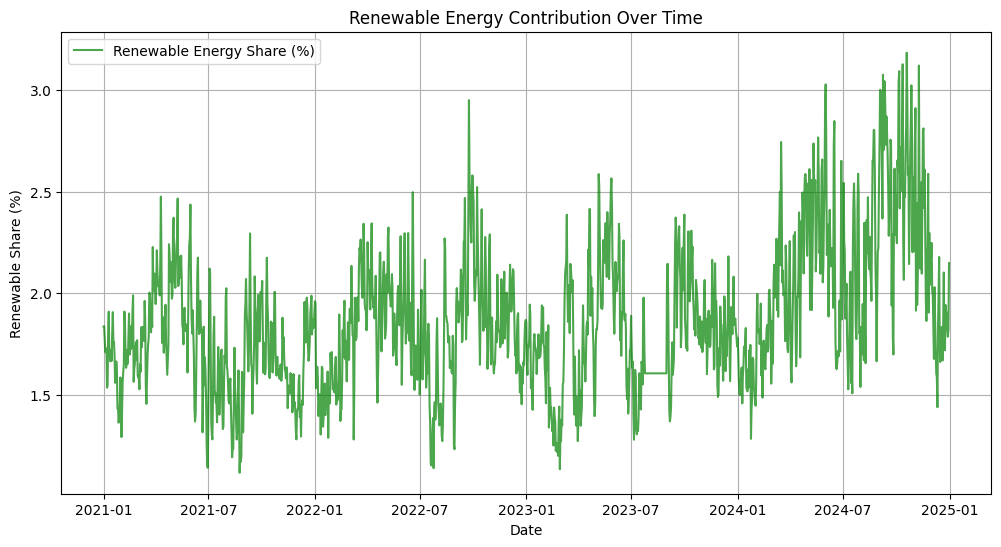

In [19]:
# Aggregate daily renewable and total generation
daily_renewable = df.groupby('Local Date')['Other Renewables Generation (MW)'].sum()
daily_total_generation = df.groupby('Local Date')['Total Generation (MW)'].sum()

# Calculate the share of renewable energy in total generation
renewable_share = (daily_renewable / daily_total_generation) * 100

# Plot renewable energy share over time
plt.figure(figsize=(12, 6))
plt.plot(renewable_share, label="Renewable Energy Share (%)", color='green', alpha=0.7)
plt.title("Renewable Energy Contribution Over Time")
plt.xlabel("Date")
plt.ylabel("Renewable Share (%)")
plt.legend()
plt.grid(True)
plt.show()


## Renewable Energy Growth Analysis:

The share of renewable energy in total electricity generation fluctuates over time.

There is a visible upward trend in renewable energy contribution, indicating increased adoption of sustainable energy sources.

Periodic dips may indicate seasonal variability in renewable energy production (e.g., lower solar or wind power during certain months).

- Peak Demand Days: Occur mainly in summer (June - August), aligning with high air conditioning usage.

- Peak Price Days: Mostly in winter (December - January), likely due to heating needs and price volatility.

- Renewable Energy Growth: Shows a general upward trend, though seasonal fluctuations exist.

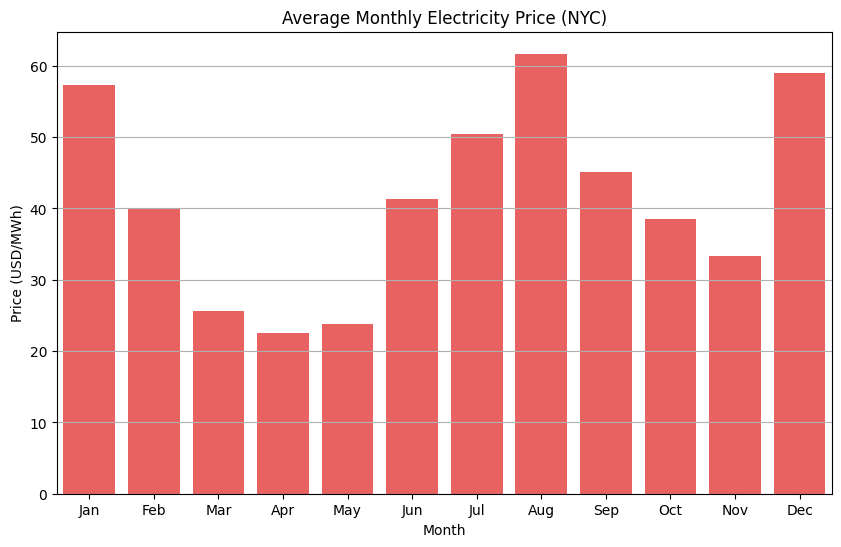

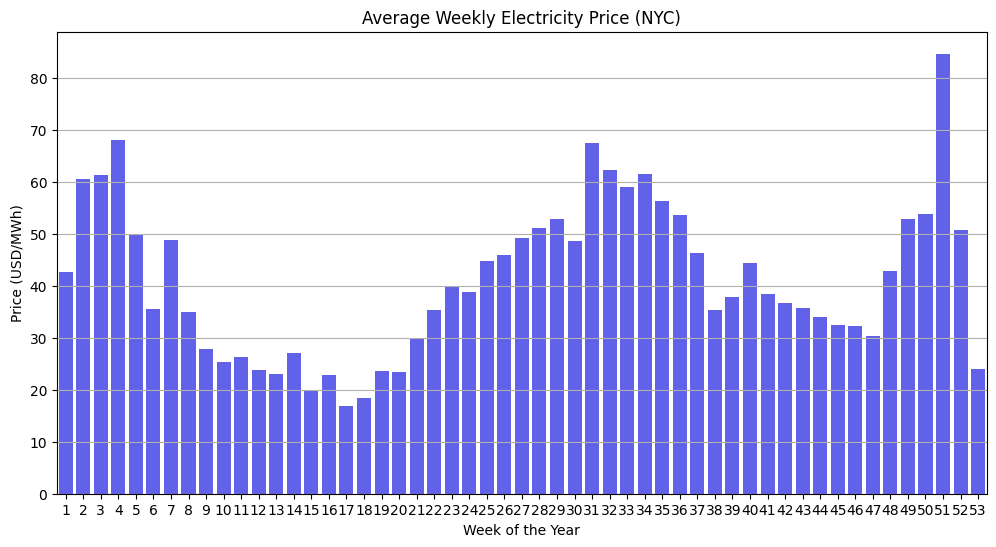

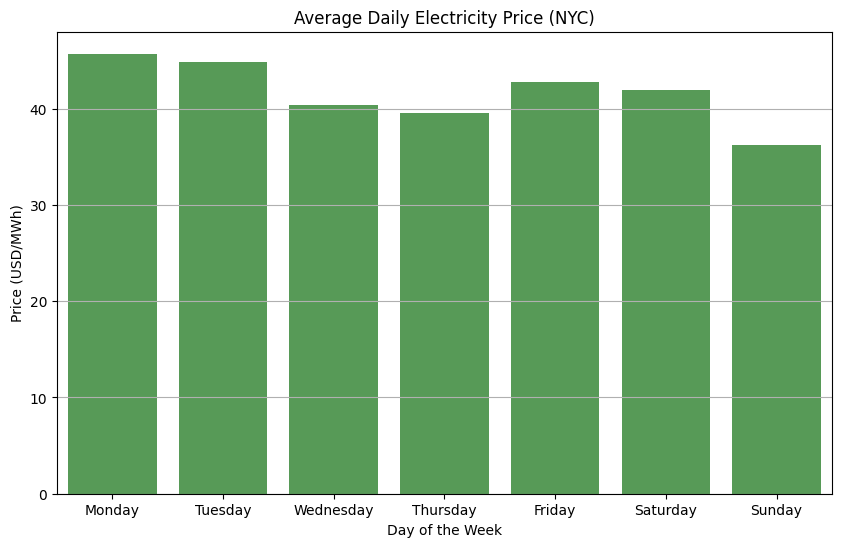

In [20]:
# Extract additional time components for grouping
df['Weekday'] = df['Local Date'].dt.day_name()
df['Week'] = df['Local Date'].dt.isocalendar().week

# Aggregate data for visualization
monthly_price_avg = df.groupby(df['Month'])['Real Time J - New York City'].mean()
weekly_price_avg = df.groupby(df['Week'])['Real Time J - New York City'].mean()
daily_price_avg = df.groupby(df['Weekday'])['Real Time J - New York City'].mean()

# Order weekdays for proper visualization
ordered_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_price_avg = daily_price_avg.reindex(ordered_weekdays)

# 1. Monthly Average Electricity Price (Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_price_avg.index, y=monthly_price_avg.values, color="red", alpha=0.7)
plt.title("Average Monthly Electricity Price (NYC)")
plt.xlabel("Month")
plt.ylabel("Price (USD/MWh)")
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.show()

# 2. Weekly Average Electricity Price (Bar Plot)
plt.figure(figsize=(12, 6))
sns.barplot(x=weekly_price_avg.index, y=weekly_price_avg.values, color="blue", alpha=0.7)
plt.title("Average Weekly Electricity Price (NYC)")
plt.xlabel("Week of the Year")
plt.ylabel("Price (USD/MWh)")
plt.grid(axis='y')
plt.show()

# 3. Daily Average Electricity Price (Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_price_avg.index, y=daily_price_avg.values, color="green", alpha=0.7)
plt.title("Average Daily Electricity Price (NYC)")
plt.xlabel("Day of the Week")
plt.ylabel("Price (USD/MWh)")
plt.grid(axis='y')
plt.show()


## Monthly Price Trends:

- Electricity prices tend to peak during winter (Jan, Feb) and summer (Jul - Aug) due to heating and cooling demands.
- Prices dip during spring and fall, when energy consumption is lower.

## Weekly Price Trends:

- Prices fluctuate across the weeks of the year, reflecting seasonal demand and market variations.
- Some weeks show significant spikes, possibly due to extreme weather events or policy changes.

## Daily Price Trends:

- Weekdays (Monday - Tuesday) have slightly higher electricity prices than weekends, likely due to business and commercial activities.
- Weekends (Saturday, Sunday) show slightly lower prices, indicating reduced industrial and commercial energy use.

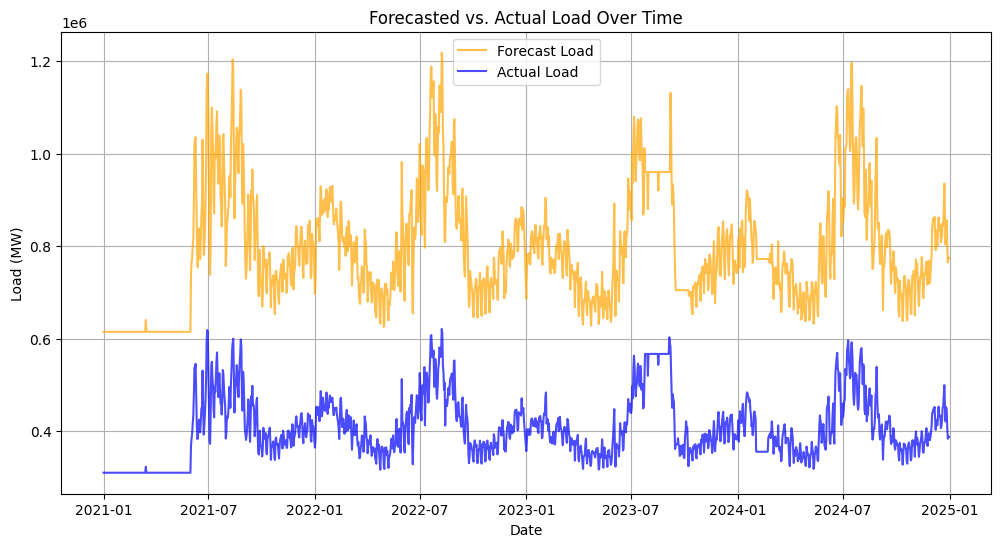

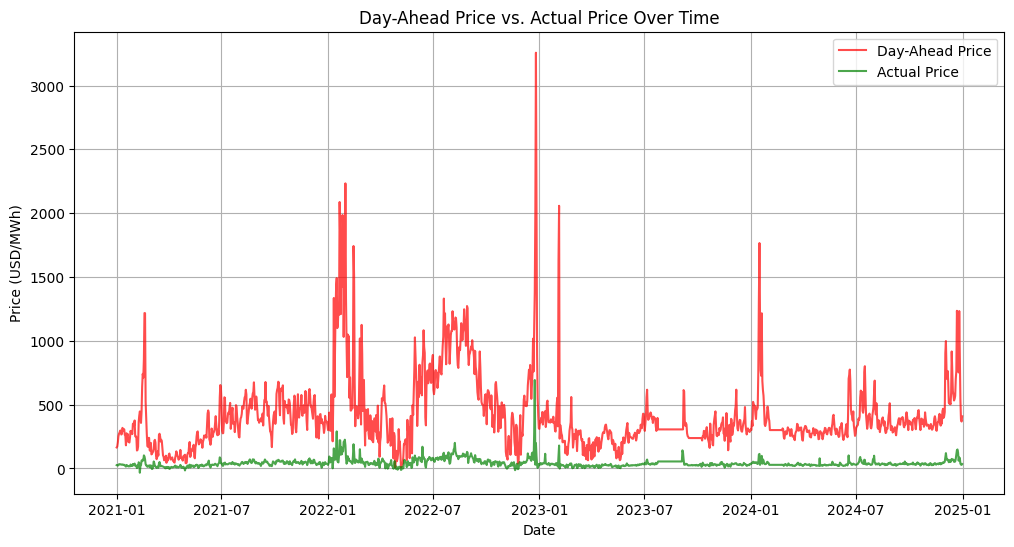

In [21]:
# Identify relevant columns for Forecast Load, Actual Load, Day-Ahead Price, and Actual Price
forecast_load_columns = [col for col in df.columns if "Forecast Load" in col]
actual_load_columns = [col for col in df.columns if "Actual Load" in col]
day_ahead_price_column = [col for col in df.columns if "DAMP" in col]  # DAMP = Day Ahead Market Price
actual_price_column = "Real Time J - New York City"  # Using NYC as representative

# Aggregate daily data for visualization
daily_forecast_load = df.groupby('Local Date')[forecast_load_columns].sum()
daily_actual_load = df.groupby('Local Date')[actual_load_columns].sum()
daily_day_ahead_price = df.groupby('Local Date')[day_ahead_price_column].mean()
daily_actual_price = df.groupby('Local Date')[actual_price_column].mean()

# Plot forecasted vs actual load
plt.figure(figsize=(12, 6))
plt.plot(daily_forecast_load.sum(axis=1), label="Forecast Load", color='orange', alpha=0.7)
plt.plot(daily_actual_load.sum(axis=1), label="Actual Load", color='blue', alpha=0.7)
plt.title("Forecasted vs. Actual Load Over Time")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

# Plot day-ahead price vs actual price
plt.figure(figsize=(12, 6))
plt.plot(daily_day_ahead_price.sum(axis=1), label="Day-Ahead Price", color='red', alpha=0.7)
plt.plot(daily_actual_price, label="Actual Price", color='green', alpha=0.7)
plt.title("Day-Ahead Price vs. Actual Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD/MWh)")
plt.legend()
plt.grid(True)
plt.show()


## Insights from Forecast Load vs Actual Load & Day-Ahead Price vs Actual Price:

### Forecasted vs. Actual Load:

- Forecast load (orange) and actual load (blue) show similar trends, but deviations exist.
- Some days have significant forecast errors, which could impact grid stability and market operations.

### Day-Ahead vs. Actual Prices:

- Day-ahead price (red) and actual price (green) generally follow the same trend.
- However, real-time prices tend to be more volatile, showing sharp fluctuations compared to the predicted day-ahead market prices.

## Key Takeaways:

- Forecasting errors in load estimation can lead to inefficiencies in energy distribution and pricing.
- Electricity prices are unpredictable, and real-time price spikes suggest the influence of external factors (e.g., demand surges, market shocks, weather events).

#### Load forecasting accuracy needs improvement to reduce deviations.

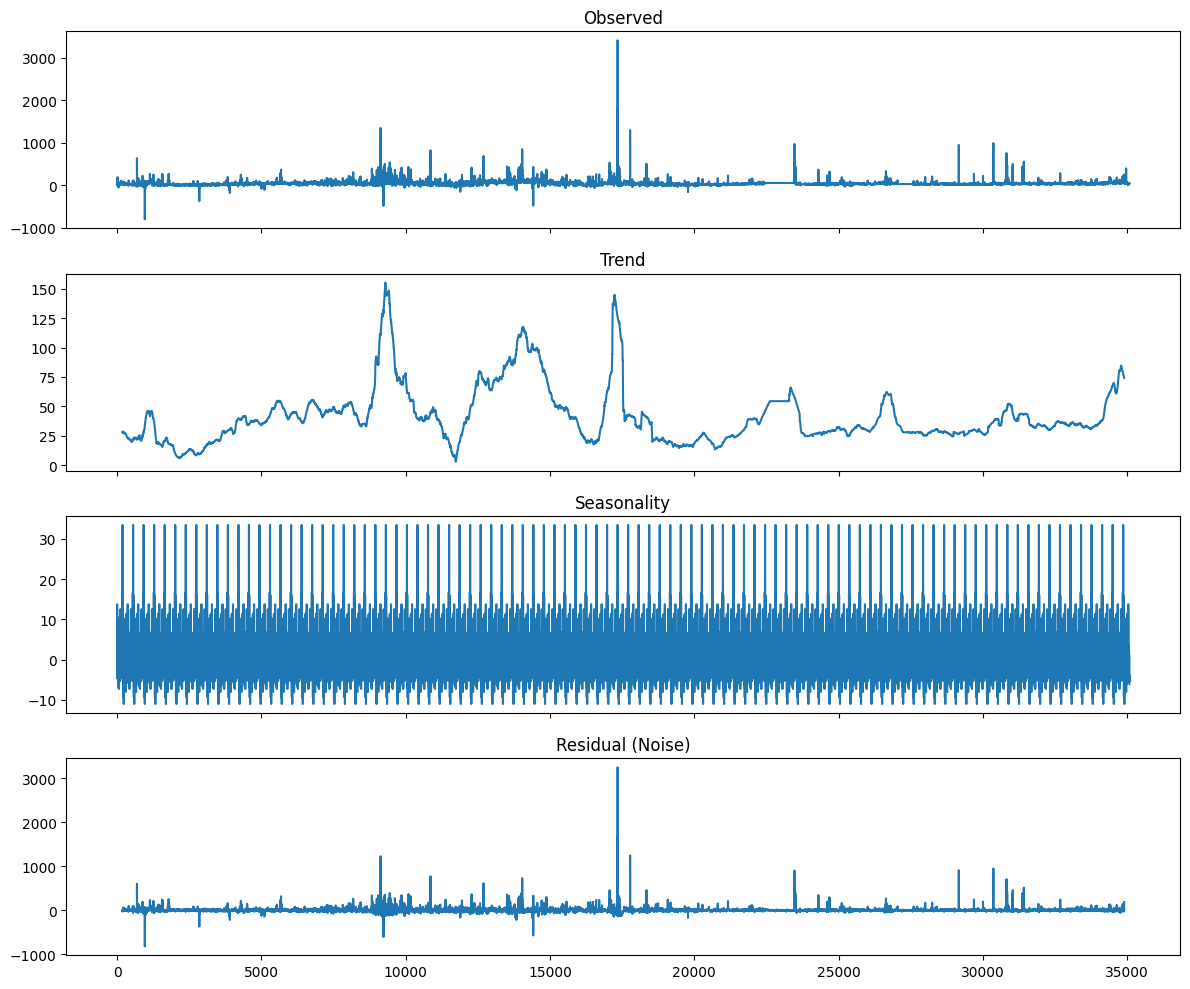

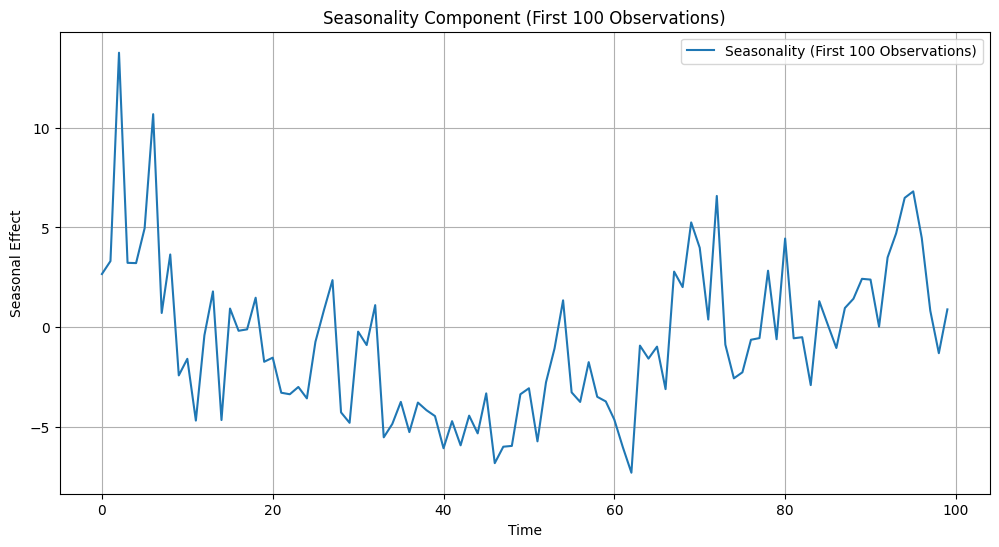

In [22]:
# Select a representative price column for analysis
price_column = 'Real Time J - New York City'

# Perform seasonal decomposition
decomposition = seasonal_decompose(df[price_column].dropna(), model='additive', period=365)

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residual (Noise)")

plt.tight_layout()
plt.show()

# Plot the first 100 observations of the seasonality component
plt.figure(figsize=(12, 6))
plt.plot(decomposition.seasonal[:100], label="Seasonality (First 100 Observations)")
plt.title("Seasonality Component (First 100 Observations)")
plt.xlabel("Time")
plt.ylabel("Seasonal Effect")
plt.legend()
plt.grid(True)
plt.show()

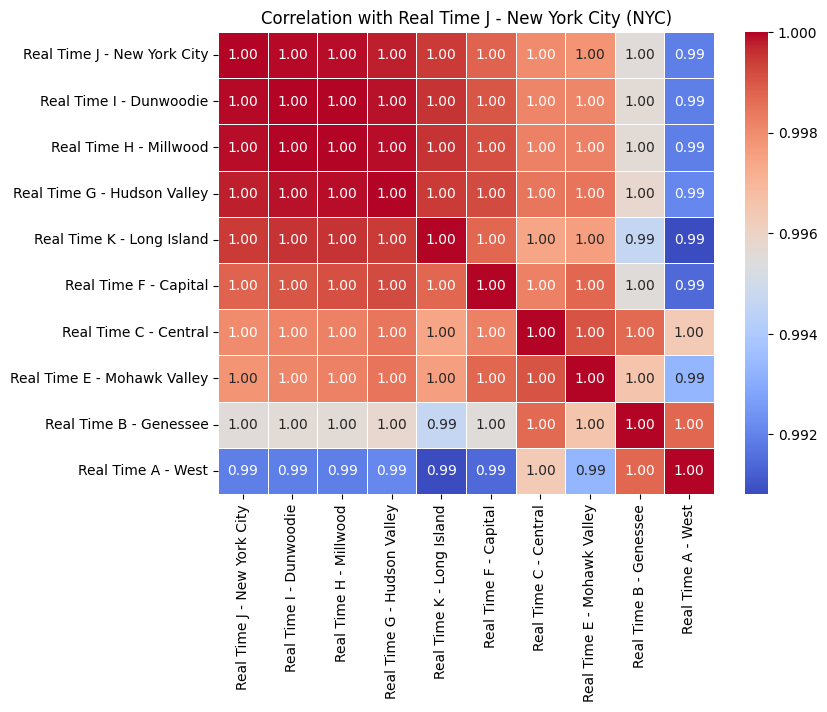


Normality Test Results:
                                                    Normally Distributed
Hour Number                                                        False
Total Generation (MW)                                              False
Dual Fuel Generation (MW)                                          False
Hydro Generation (MW)                                              False
Natural Gas Generation (MW)                                        False
Nuclear Generation (MW)                                            False
Other Fossil Fuels Generation (MW)                                 False
Other Renewables Generation (MW)                                   False
Wind Generation (MW)                                               False
DAMP A - West                                                      False
DAMP B - Genessee                                                  False
DAMP C - Central                                                   False
DAMP D - North            

In [23]:
import scipy.stats as stats

# Select numerical columns including price
df_numeric = df.select_dtypes(include=[np.number])

# Drop rows with NaN values
df_numeric = df_numeric.dropna()

# Dictionary to store normality test results
normality_results = {}

# Perform Shapiro-Wilk test for normality (only works for sample size ≤ 5000)
for col in df_numeric.columns:
    if len(df_numeric[col]) > 5000:
        normality_results[col] = False  # Assume non-normal for large samples
    else:
        stat, p = stats.shapiro(df_numeric[col])
        normality_results[col] = p > 0.05  # True if normally distributed

# Separate normal and non-normal variables
normal_vars = [col for col, is_normal in normality_results.items() if is_normal]
non_normal_vars = [col for col in normality_results if col not in normal_vars]

# Compute correlation matrices
pearson_corr = df_numeric[[price_column] + normal_vars].corr(method='pearson') if normal_vars else None
spearman_corr = df_numeric[[price_column] + non_normal_vars].corr(method='spearman') if non_normal_vars else None

# Use Spearman correlation for visualization
corr_matrix = df_numeric.corr(method='spearman')

# Limit matrix to top 10 correlated features with the NYC price column
top_corr_features = corr_matrix[price_column].abs().sort_values(ascending=False).head(10).index
corr_matrix_limited = corr_matrix.loc[top_corr_features, top_corr_features]

# Visualization: Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_limited, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Correlation with {price_column} (NYC)")
plt.show()

# Print results
print("\nNormality Test Results:")
print(pd.DataFrame.from_dict(normality_results, orient='index', columns=['Normally Distributed']))

if pearson_corr is not None:
    print(f"\nPearson Correlation (For Normally Distributed Variables - {price_column}):")
    print(pearson_corr)

if spearman_corr is not None:
    print(f"\nSpearman Correlation (For Non-Normally Distributed Variables - {price_column}):")
    print(spearman_corr)

In [24]:
# Drop missing values in the price column
df_price = df[[price_column]].dropna()

# Perform the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df_price[price_column])

# Prepare results
adf_output = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Critical Values": adf_result[4]
}

# Display results manually
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])


ADF Statistic: -13.47482245206745
p-value: 3.3279410481360675e-25
Critical Values: {'1%': -3.430536685485436, '5%': -2.861622510373584, '10%': -2.5668139176782314}


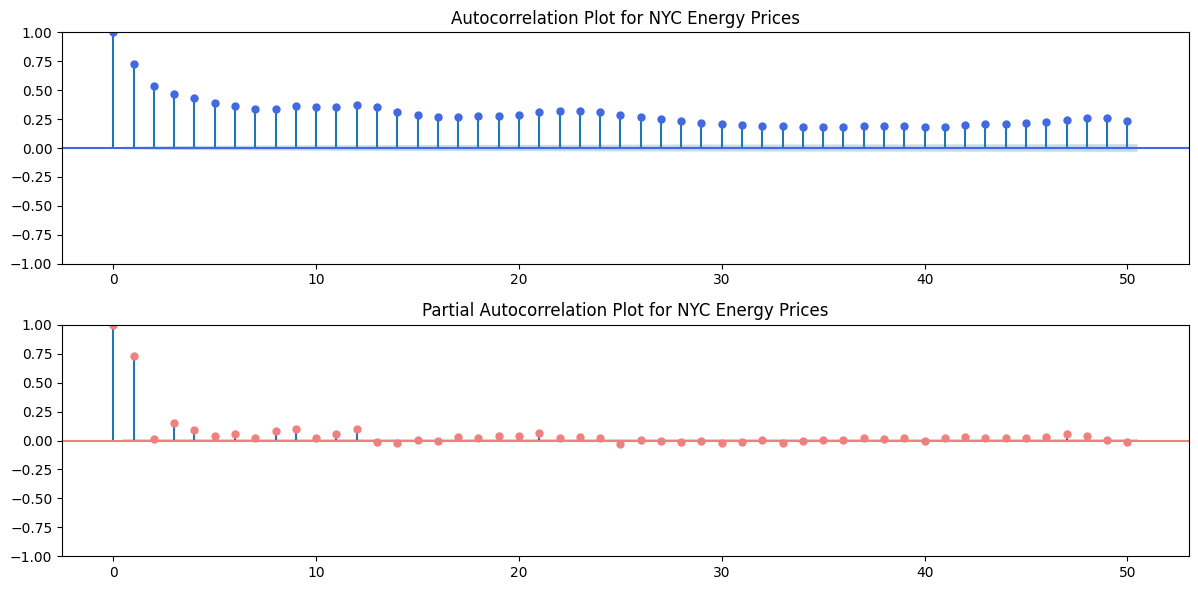

In [25]:
# Create subplots for ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Plot Autocorrelation (ACF)
plot_acf(df_price[price_column], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot for NYC Energy Prices')

# Plot Partial Autocorrelation (PACF)
plot_pacf(df_price[price_column], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot for NYC Energy Prices')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

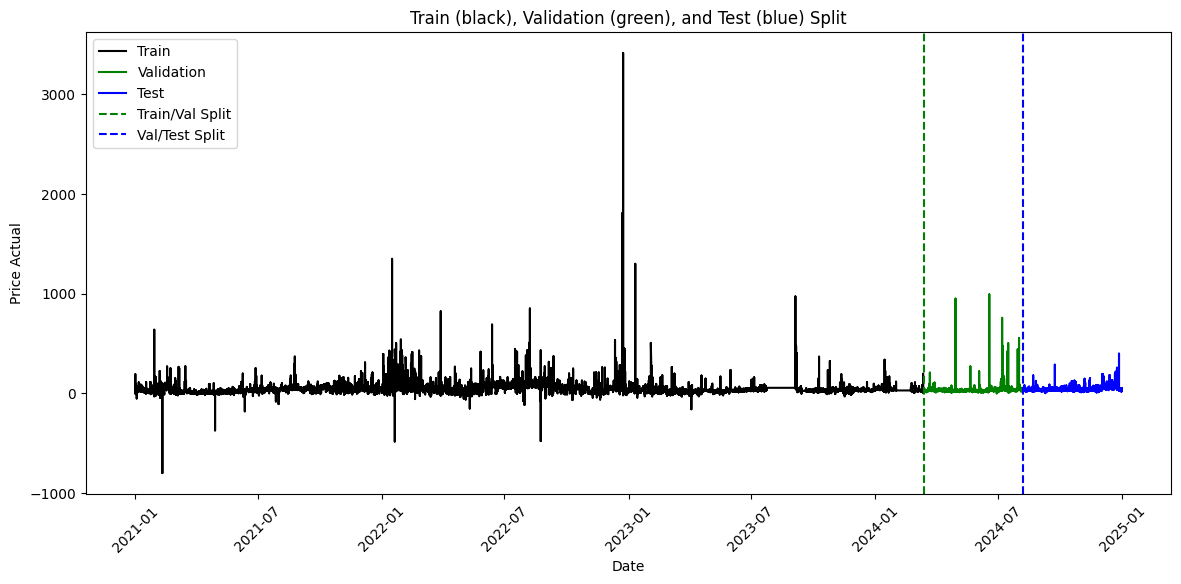

In [26]:
# Ensure the price column exists
if price_column not in df.columns:
    raise KeyError(f"Column '{price_column}' not found in dataset. Available columns:\n{df.columns}")

# Drop non-numeric columns (like dates & categories)
df_numeric = df.select_dtypes(include=[np.number])

# Separate features and target variable
X = df_numeric.drop(columns=[price_column])
y = df_numeric[[price_column]]

# Function to apply PCA safely
def apply_PCA(X_input, cum_variance, if_apply):
    if if_apply:
        pca = PCA(n_components=cum_variance)
        scaler_pca = make_pipeline(MinMaxScaler(), pca)
        X_pca = scaler_pca.fit_transform(X_input)
        return X_pca
    else:
        return np.array(X_input)

# Apply PCA with 80% variance retained
params_pca = {'cum_variance': 0.8, 'if_apply': True}
X_pca = apply_PCA(X, **params_pca)

# Splitting dataset
train_cutoff = int(0.8 * X_pca.shape[0])
val_cutoff = int(0.9 * X_pca.shape[0])

# Normalize target variable
scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)


# Function to apply windowing
def windowing(X_input, y_input, history_size):
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size: i, :])
        labels.append(y_input[i])
    return np.array(data), np.array(labels).reshape(-1, 1)

# History size for look-back
hist_size = 24

# Concatenating normalized features and target variable
data_norm = np.concatenate((X_pca, y_norm), axis=1)

# Creating training, validation, and test sets
X_train, y_train = windowing(data_norm[:train_cutoff, :], data_norm[:train_cutoff, -1], hist_size)
X_val, y_val = windowing(data_norm[train_cutoff:val_cutoff, :], data_norm[train_cutoff:val_cutoff, -1], hist_size)
X_test, y_test = windowing(data_norm[val_cutoff:, :], data_norm[val_cutoff:, -1], hist_size)

# Convert "Local Date" column to datetime format
date_column = "Local Date"

# Ensure the column exists
if date_column in df.columns:
    df[date_column] = pd.to_datetime(df[date_column])
else:
    raise KeyError(f"Column '{date_column}' not found in dataset. Available columns:\n{df.columns}")

# Visualization of train-test split using Local Date on x-axis
fig, axes = plt.subplots(figsize=(14, 6))

axes.plot(df[date_column][:train_cutoff], y[:train_cutoff], color='black', label='Train')
axes.plot(df[date_column][train_cutoff + 1:val_cutoff], y.iloc[train_cutoff + 1: val_cutoff], color='green', label='Validation')
axes.plot(df[date_column][val_cutoff + 1:], y.iloc[val_cutoff + 1:], color='blue', label='Test')

axes.axvline(x=df[date_column].iloc[train_cutoff], color='green', linestyle='--', label='Train/Val Split')
axes.axvline(x=df[date_column].iloc[val_cutoff], color='blue', linestyle='--', label='Val/Test Split')

axes.set_title('Train (black), Validation (green), and Test (blue) Split')
axes.set_xlabel('Date')
axes.set_ylabel('Price Actual')
axes.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


# Forecasting
## XGBoost

Sample y_test_inv (Actual Prices): [32.15 27.57 21.22 23.2  22.1 ]
Sample y_pred_actual (Predicted Prices): [32.04254  27.567219 21.228834 23.218885 22.426369]



---------------------------------------------------
XGBoost MAE for test set (Actual Prices): 0.3
---------------------------------------------------




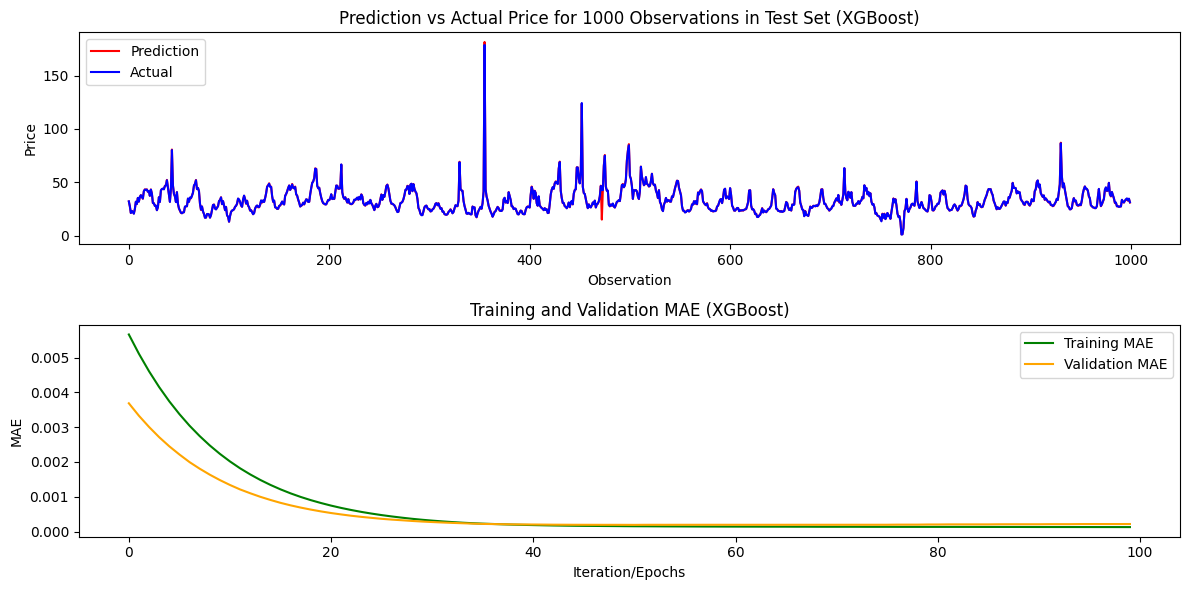

In [27]:
from sklearn.model_selection import train_test_split

# Normalize target variable
scaler_y = MinMaxScaler()
y_norm = scaler_y.fit_transform(y)

# Ensure no NaN or infinite values in y_norm
y_norm = np.nan_to_num(y_norm, nan=0.0, posinf=0.0, neginf=0.0)

# Split into training, validation, and testing sets (80-10-10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_norm.flatten(), test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Convert target variables to NumPy arrays
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Function to reshape data for XGBoost
def reshaping(X):
    return X.to_numpy().reshape(X.shape[0], -1)  # Convert to NumPy first

X_train_xgb = reshaping(X_train)
X_val_xgb = reshaping(X_val)
X_test_xgb = reshaping(X_test)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric="mae"
)

# Fit the model with **both training and validation sets in eval_set**
xgb_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)],  # Include training data in eval_set
    verbose=False
)

# Make predictions
y_pred = xgb_model.predict(X_test_xgb)

# **Fix: Ensure inverse transformation is correctly applied**
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)

# **Fix: Calculate MAE in actual price scale**
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Function to plot results with **both Training and Validation MAE**
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    ax[0].plot(y_pred_actual[:1000], color='red', label='Prediction')
    ax[0].plot(y_test_inv[:1000], color='blue', label='Actual')
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Prediction vs Actual Price for 1000 Observations in Test Set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')

    if model_name == 'XGBoost':
        evals_result = model.evals_result()
        train_mae = evals_result['validation_0']['mae']
        val_mae = evals_result['validation_1']['mae']

        ax[1].plot(train_mae, label='Training MAE', color='green')
        ax[1].plot(val_mae, label='Validation MAE', color='orange')

        ax[1].legend()
        ax[1].set_title(f'Training and Validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')

    fig.tight_layout()
    plt.show()

# **Print sample values for debugging**
print("Sample y_test_inv (Actual Prices):", y_test_inv[:5].flatten())
print("Sample y_pred_actual (Predicted Prices):", y_pred_actual[:5].flatten())

# **Fix: Display MAE on actual price scale**
print('\n' * 2)
print('---------------------------------------------------')
print(f'XGBoost MAE for test set (Actual Prices): {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')

# Call function with trained XGBoost model
plot_results(y_pred_actual, y_test_inv, xgb_model, 'XGBoost')

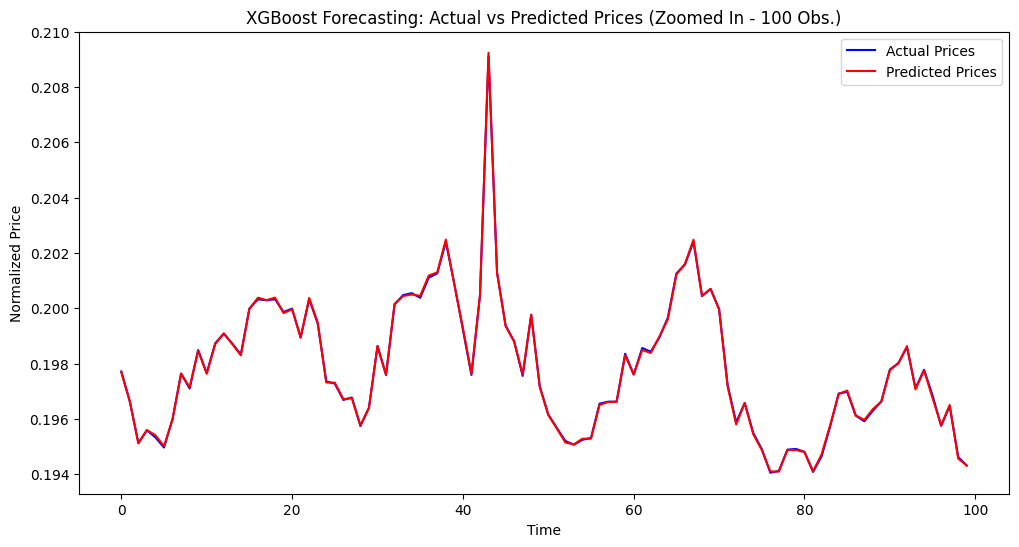

In [28]:
# **Plot 1000 observations for a closer look**
subset_size = min(100, len(y_test))  # Ensure we don't exceed available data

plt.figure(figsize=(12, 6))
plt.plot(range(subset_size), y_test[:subset_size], label="Actual Prices", color="blue")
plt.plot(range(subset_size), y_pred[:subset_size], label="Predicted Prices", color="red")
plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.title("XGBoost Forecasting: Actual vs Predicted Prices (Zoomed In - 100 Obs.)")
plt.legend()
plt.show()

# GRU

In [29]:
# **Fix: Reshape X to be compatible with GRU**
X_train = np.array(X_train, dtype=np.float32).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = np.array(X_val, dtype=np.float32).reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = np.array(X_test, dtype=np.float32).reshape(X_test.shape[0], X_test.shape[1], 1)


In [34]:
# Define GRU model
def base_model_gru():
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        GRU(units=64, return_sequences=True, activation="tanh"),  # **Increased units & changed activation**
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.2),  # **Increased dropout to prevent overfitting**
        Dense(1)
    ])
    return model

gru_model = base_model_gru()

# Hyperparameters
epoch = 150  # **Increased epochs**
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3, amsgrad=True)


# Compile and train GRU model
gru_model.compile(optimizer=optimizer, loss='mean_absolute_error')
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

# Make predictions
y_pred = gru_model.predict(X_test)
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Compute MAE
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Display results
print('\n' * 2)
print('---------------------------------------------------')
print(f'GRU MAE for test set (Actual Prices): {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')



Epoch 1/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - loss: 0.0359 - val_loss: 0.0120
Epoch 2/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0095 - val_loss: 0.0014
Epoch 3/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 4/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 5/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - loss: 0.0021 - val_loss: 8.8669e-04
Epoch 6/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - loss: 0.0018 - val_loss: 8.1593e-04
Epoch 7/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - loss: 0.0018 - val_loss: 6.2564e-04
Epoch 8/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - loss: 0.0016 - val_loss: 9.0651e-04
Epoch 9/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0017 - val_loss: 9.6574e-04
Epoch 10/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - loss: 0.0015 - val_loss: 7.5376e-04
Epoch 11/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 0.0014 - val_loss: 9.

In [35]:
print(history.history.keys())  # Should output: dict_keys(['loss', 'val_loss'])
print(history.history)  # Check if values exist


dict_keys(['loss', 'val_loss'])
{'loss': [0.019133586436510086, 0.007890063337981701, 0.0030501086730509996, 0.0021302904933691025, 0.002049953443929553, 0.0018551356624811888, 0.0018227497348561883, 0.0017109995242208242, 0.0016493475995957851, 0.0014791367575526237, 0.0014881315873935819, 0.0014238391304388642, 0.0013032244751229882, 0.0013469061814248562, 0.001307223690673709, 0.0013220194960013032, 0.001232922193594277, 0.001186547800898552, 0.0012753113405779004, 0.0012526587815955281, 0.001199290039949119, 0.0011711532715708017, 0.0011649879161268473], 'val_loss': [0.011962112970650196, 0.00141834223177284, 0.001835868344642222, 0.0028453099075704813, 0.0008866861462593079, 0.0008159263525158167, 0.0006256367778405547, 0.0009065093472599983, 0.0009657398331910372, 0.0007537559722550213, 0.000996737158857286, 0.0006331581971608102, 0.0012248283019289374, 0.0009648592094890773, 0.00042247248347848654, 0.0006228048005141318, 0.0011643741745501757, 0.0006482511525973678, 0.0013363447

Training MAE: [0.019133586436510086, 0.007890063337981701, 0.0030501086730509996, 0.0021302904933691025, 0.002049953443929553, 0.0018551356624811888, 0.0018227497348561883, 0.0017109995242208242, 0.0016493475995957851, 0.0014791367575526237, 0.0014881315873935819, 0.0014238391304388642, 0.0013032244751229882, 0.0013469061814248562, 0.001307223690673709, 0.0013220194960013032, 0.001232922193594277, 0.001186547800898552, 0.0012753113405779004, 0.0012526587815955281, 0.001199290039949119, 0.0011711532715708017, 0.0011649879161268473]
Validation MAE: [0.011962112970650196, 0.00141834223177284, 0.001835868344642222, 0.0028453099075704813, 0.0008866861462593079, 0.0008159263525158167, 0.0006256367778405547, 0.0009065093472599983, 0.0009657398331910372, 0.0007537559722550213, 0.000996737158857286, 0.0006331581971608102, 0.0012248283019289374, 0.0009648592094890773, 0.00042247248347848654, 0.0006228048005141318, 0.0011643741745501757, 0.0006482511525973678, 0.001336344750598073, 0.000573339755

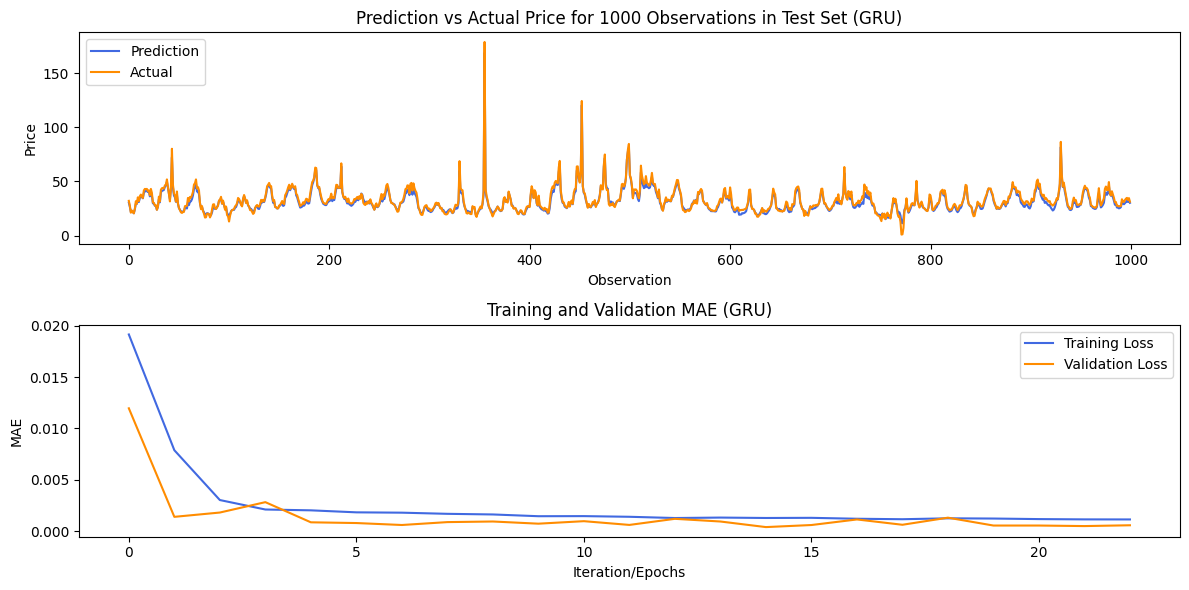

In [36]:
def plot_results(y_pred_actual, y_test_inv, history, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    # Prediction vs Actual Prices
    ax[0].plot(y_pred_actual[:1000], color='royalblue', label='Prediction')
    ax[0].plot(y_test_inv[:1000], color='darkorange', label='Actual')
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Prediction vs Actual Price for 1000 Observations in Test Set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')

    # Training and Validation MAE
    if history is not None:
        try:
            train_mae = history.history['loss']
            val_mae = history.history['val_loss']

            print("Training MAE:", train_mae)  # ✅ Debugging
            print("Validation MAE:", val_mae)  # ✅ Debugging

            ax[1].plot(train_mae, label='Training Loss', color='royalblue')
            ax[1].plot(val_mae, label='Validation Loss', color='darkorange')
            ax[1].legend()
            ax[1].set_title(f'Training and Validation MAE ({model_name})')
            ax[1].set_xlabel('Iteration/Epochs')
            ax[1].set_ylabel('MAE')
        except KeyError:
            print("Error: 'loss' and 'val_loss' keys not found in history.history")

    fig.tight_layout()
    plt.show()

plot_results(y_pred_actual, y_test_inv, history, 'GRU')


# LSTM

In [37]:
# Define LSTM model
def base_model_lstm():
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(units=64, return_sequences=True, activation="tanh"),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 57, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3648)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         467,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,924,294 (7.34 MB)

 Trainable params: 484,097 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,440,197 (5.49 MB)

Epoch 1/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - loss: 0.0340 - val_loss: 0.0105
Epoch 2/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 0.0091 - val_loss: 0.0047
Epoch 3/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - loss: 0.0044 - val_loss: 8.8243e-04
Epoch 4/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 5/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 8/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 10/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0015 - val_loss: 4.8740e-04
Epoch 11/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0014 - val_loss: 7.2076e-04
Epoch 1

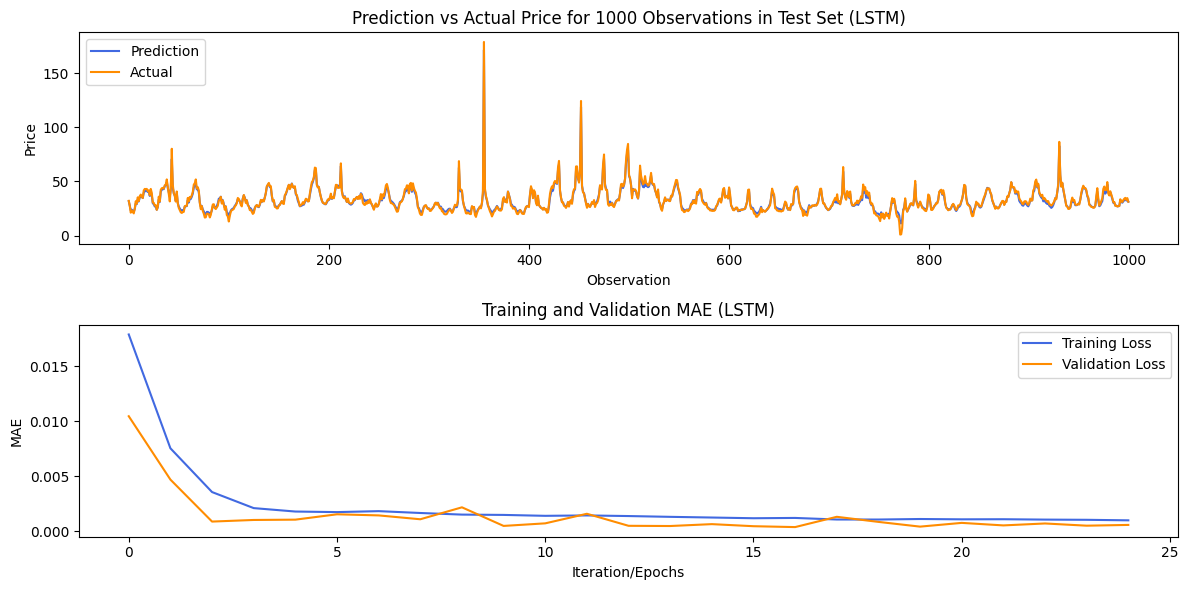

In [38]:
# Hyperparameters
epoch = 150
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3, amsgrad=True)

# Compile and train LSTM model
lstm_model.compile(optimizer=optimizer, loss='mean_absolute_error')
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

# Make predictions
y_pred = lstm_model.predict(X_test)

# Inverse transform predictions
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Compute MAE
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Display results
print('\n' * 2)
print('---------------------------------------------------')
print(f'LSTM MAE for test set (Actual Prices): {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')

# Plot results
plot_results(y_pred_actual, y_test_inv, history, 'LSTM')


# CNN

In [52]:
# Define CNN model
def base_model_cnn():
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

In [53]:
cnn_model = base_model_cnn()

# Hyperparameters
epoch = 150
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3, amsgrad=True)

# Compile and train CNN model
cnn_model.compile(optimizer=optimizer, loss='mean_absolute_error')
cnn_model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 57, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,889 (898.00 KB)

 Trainable params: 229,889 (898.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0255 - val_loss: 0.0021
Epoch 2/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0091 - val_loss: 0.0024
Epoch 3/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 4/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 6/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 7/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0018 - val_loss: 7.5475e-04
Epoch 9/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 11/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0016 - val_loss: 4.5907e-04
Epoch 12/150
439/439

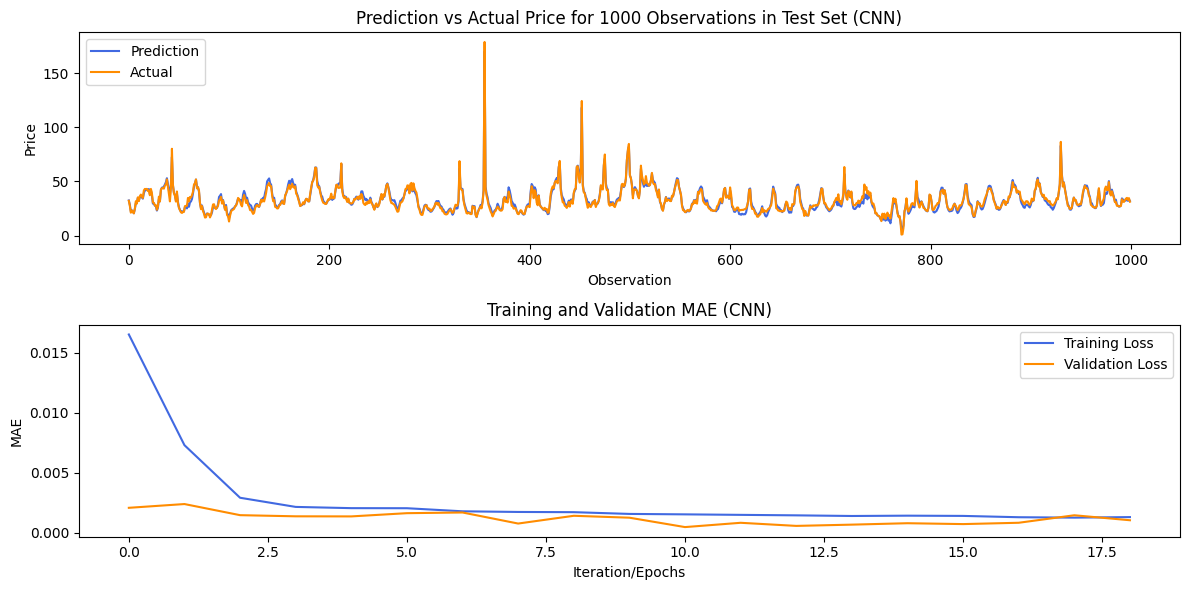

In [54]:
history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch,
                        batch_size=batch_size, callbacks=[callback])

# Make predictions
y_pred = cnn_model.predict(X_test)

# Compute MAE
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Display results
print('\n' * 2)
print('---------------------------------------------------')
print(f'CNN MAE for test set : {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')

# Plot results
plot_results(y_pred_actual, y_test_inv, history, 'CNN')


# CNN-LSTM

In [55]:
# Define CNN-LSTM model
def base_model_cnn_lstm():
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        LSTM(units=64, return_sequences=True, activation="tanh"),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

cnn_lstm_model = base_model_cnn_lstm()
cnn_lstm_model.compile(optimizer=optimizer, loss='mean_absolute_error')
cnn_lstm_model.summary()

In [56]:
# Hyperparameters
epoch = 150
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3, amsgrad=True)

In [57]:
# Compile and train CNN-LSTM model
cnn_lstm_model.compile(optimizer=optimizer, loss='mean_absolute_error')
history = cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch,
                        batch_size=batch_size, callbacks=[callback])


Epoch 1/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - loss: 0.0219 - val_loss: 0.0033
Epoch 2/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0080 - val_loss: 0.0027
Epoch 3/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 4/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 5/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0021 - val_loss: 6.3329e-04
Epoch 8/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0015 - val_loss: 5.9609e-04
Epoch 12/15

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step



---------------------------------------------------
CNN-LSTM MAE for test set : 1.344
---------------------------------------------------


Training MAE: [0.01399924699217081, 0.007190140429884195, 0.004136101342737675, 0.0026253487449139357, 0.002113484777510166, 0.0019802702590823174, 0.0018657753244042397, 0.0017208707286044955, 0.0015363864367827773, 0.0014938557287678123, 0.0014447052963078022, 0.0013721532886847854, 0.001344389864243567, 0.001191499293781817, 0.001130756689235568, 0.0011450840393081307, 0.0011647336650639772, 0.0011815918842330575, 0.0010768900392577052, 0.0010501783108338714, 0.0010378244332969189, 0.0010419266764074564, 0.0010027182288467884, 0.0009657581686042249, 0.0010250193299725652, 0.0009946569334715605, 0.0009532108088023961, 0.0009823504369705915, 0.0010246989550068974, 0.0008877856307663023, 0.0009538604062981904, 0.0009221037034876645, 0.0009025476756505668, 0.0009435752290301025, 0.0009186082170344889, 0.00

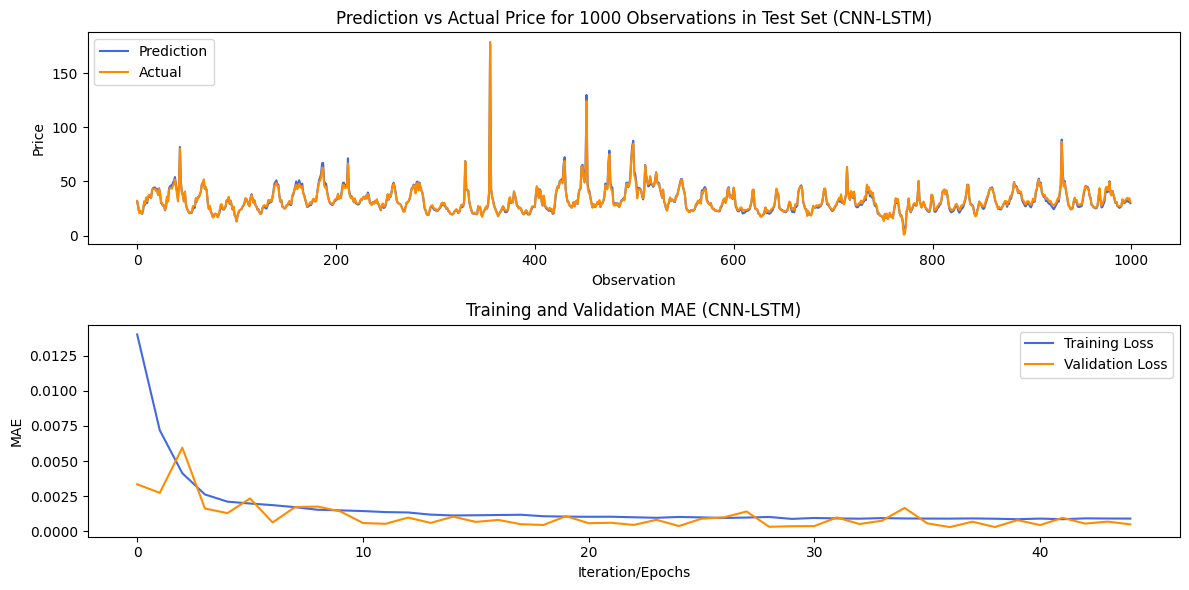

In [58]:
# Make predictions
y_pred = cnn_lstm_model.predict(X_test)

# Compute MAE
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Display results
print('\n' * 2)
print('---------------------------------------------------')
print(f'CNN-LSTM MAE for test set : {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')

# Plot results
plot_results(y_pred_actual, y_test_inv, history, 'CNN-LSTM')

# LSTM_Attention

In [31]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten, Layer
# Define custom Attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


In [32]:
# Define LSTM with Attention model
def base_model_lstm_attention():
    inputs = Input(shape=(X_train.shape[1], 1))
    lstm_out = LSTM(units=64, return_sequences=True, activation="tanh")(inputs)
    attention = Attention()(lstm_out)
    flatten = Flatten()(attention)
    dense1 = Dense(units=128, activation='relu')(flatten)
    dropout = Dropout(0.2)(dense1)
    output = Dense(1)(dropout)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

lstm_attention_model = base_model_lstm_attention()
lstm_attention_model.compile(optimizer=optimizer, loss='mean_absolute_error')
lstm_attention_model.summary()

NameError: name 'optimizer' is not defined

In [42]:
# Hyperparameters
epoch = 150
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3, amsgrad=True)

# Compile and train LSTM-Attention model
lstm_attention_model.compile(optimizer=optimizer, loss='mean_absolute_error')
history = lstm_attention_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch,
                                   batch_size=batch_size, callbacks=[callback])


Epoch 1/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.0250 - val_loss: 0.0056
Epoch 2/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0083 - val_loss: 0.0039
Epoch 3/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 4/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 5/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 6/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 7/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 8/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 9/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 10/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 11/150
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 12/150
439/43

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step



---------------------------------------------------
LSTM-Attention MAE for test set : 1.314
---------------------------------------------------


Training MAE: [0.01442360132932663, 0.007550184149295092, 0.005410727113485336, 0.004421220161020756, 0.0039049675688147545, 0.003729250282049179, 0.003605967853218317, 0.0035555146168917418, 0.003494430333375931, 0.0033982833847403526, 0.003376181237399578, 0.0033021674025803804, 0.003308250103145838, 0.0032059666700661182, 0.003219200298190117, 0.003138790838420391, 0.0030879126861691475, 0.003013888606801629, 0.002955084666609764, 0.0028860827442258596, 0.002812169259414077, 0.0027052301447838545, 0.002637055004015565, 0.0024817469529807568, 0.0023109058383852243, 0.0020870468579232693, 0.0019867585506290197, 0.0017872439930215478, 0.0017310240073129535, 0.0016063331859186292, 0.001457182108424604, 0.0014834065223112702, 0.0013275517849251628, 0.0013655077200382948, 0.0013201494002714753, 0.0012

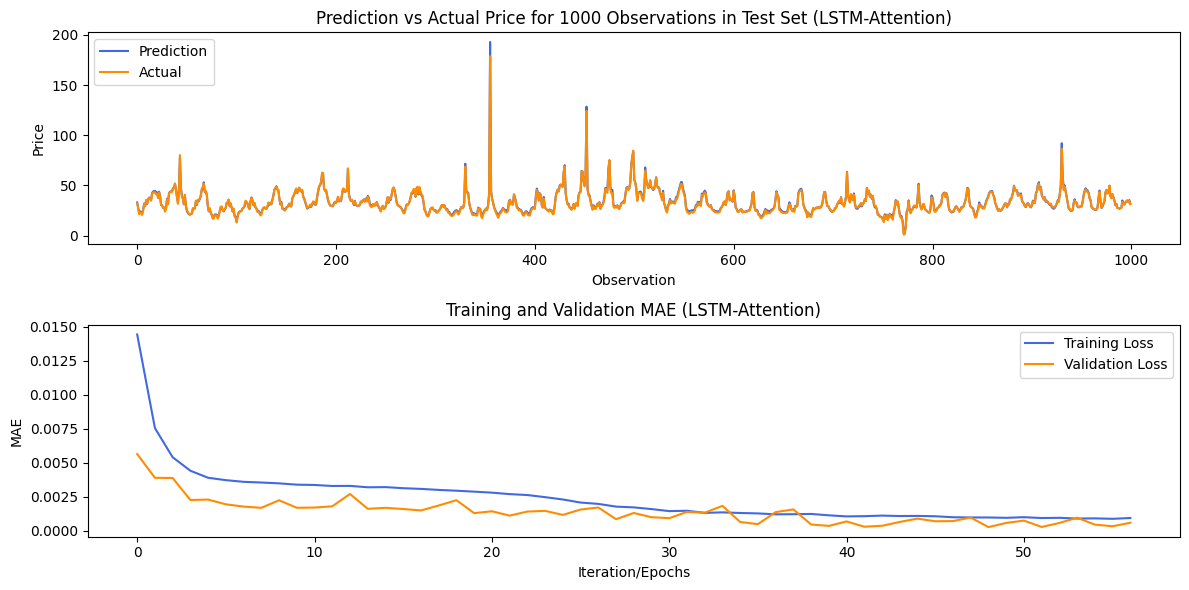

In [43]:
# Make predictions
y_pred = lstm_attention_model.predict(X_test)

# Compute MAE
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Display results
print('\n' * 2)
print('---------------------------------------------------')
print(f'LSTM-Attention MAE for test set : {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')

# Plot results
plot_results(y_pred_actual, y_test_inv, history, 'LSTM-Attention')


# Hybrid GRU-XGBoost

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 57, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3648)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         467,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 480,065 (1.83 MB)

 Trainable params: 480,065 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - loss: 0.0215 - val_loss: 0.0033
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - loss: 0.0082 - val_loss: 0.0057
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 5/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0018 - val_loss: 9.0805e-04
Epoch 6/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - loss: 0.0020 - val_loss: 6.9826e-04
Epoch 7/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - loss: 0.0018 - val_loss: 9.1467e-04
Epoch 8/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0019 - val_loss: 7.1874e-04
Epoch 9/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - loss: 0.0016 - val_loss: 6.3771e-04
Epoch 11/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0015 - val_loss: 0.0025

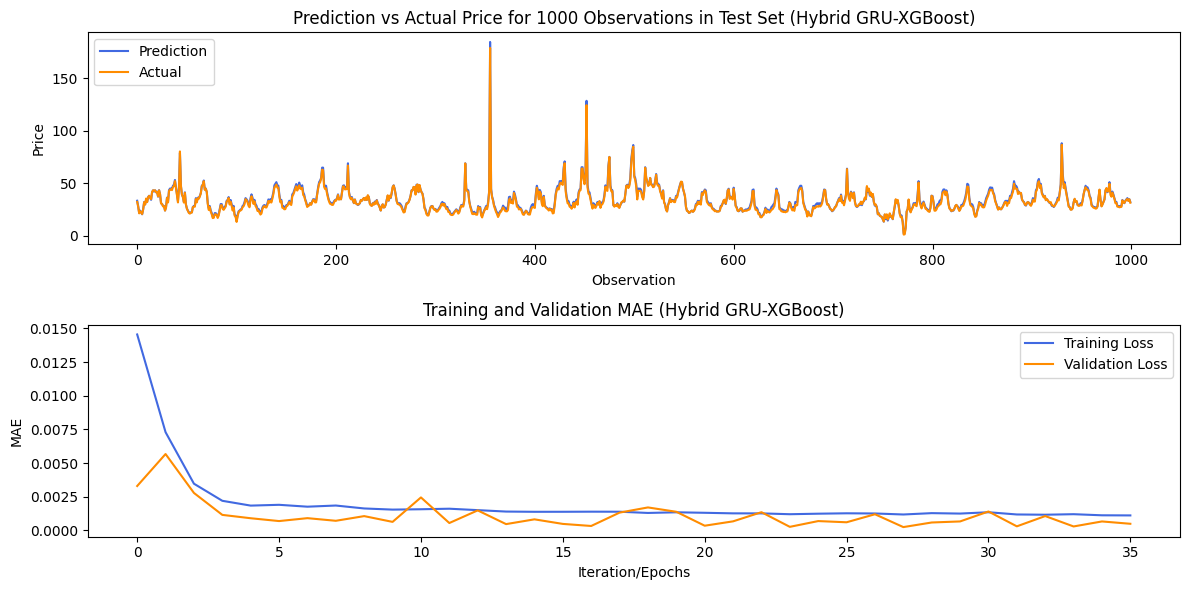

In [44]:
# Define GRU model
def base_model_gru():
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        GRU(units=64, return_sequences=True, activation="relu"),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

gru_model = base_model_gru()

# Hyperparameters
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3, amsgrad=True)

# Compile and train GRU model
gru_model.compile(optimizer=optimizer, loss='mean_absolute_error')
gru_model.compile(optimizer=optimizer, loss='mean_absolute_error')
gru_model.summary()


history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

# Extract features from GRU model
y_train_gru = gru_model.predict(X_train)
y_test_gru = gru_model.predict(X_test)

# Reshape features for XGBoost
X_train_xgb = y_train_gru.reshape(-1, 1)
X_test_xgb = y_test_gru.reshape(-1, 1)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Compute MAE
y_pred_actual = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Display results
print('\n' * 2)
print('---------------------------------------------------')
print(f'Hybrid GRU-XGBoost MAE for test set : {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')

# Plot results
plot_results(y_pred_actual, y_test_inv, history, 'Hybrid GRU-XGBoost')


# Hybrid LSTM-Attention-XGBoost

In [30]:
# Define LSTM with Attention model
def base_model_lstm_attention():
    inputs = Input(shape=(X_train.shape[1], 1))
    lstm_out = LSTM(units=64, return_sequences=True, activation="tanh")(inputs)
    attention = Attention()(lstm_out)
    flatten = Flatten()(attention)
    dense1 = Dense(units=128, activation='relu')(flatten)
    dropout = Dropout(0.2)(dense1)
    output = Dense(1)(dropout)

    model = Model(inputs=inputs, outputs=output)
    return model

lstm_attention_model = base_model_lstm_attention()

# Hyperparameters
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=1e-3, amsgrad=True)

# Compile and train LSTM-Attention model
lstm_attention_model.compile(optimizer=optimizer, loss='mean_absolute_error')
lstm_attention_model.compile(optimizer=optimizer, loss='mean_absolute_error')
lstm_attention_model.summary()


history = lstm_attention_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch,
                                   batch_size=batch_size, callbacks=[callback])

# Extract features from LSTM-Attention model
y_train_lstm = lstm_attention_model.predict(X_train)
y_test_lstm = lstm_attention_model.predict(X_test)

# Reshape features for XGBoost
X_train_xgb = y_train_lstm.reshape(-1, 1)
X_test_xgb = y_test_lstm.reshape(-1, 1)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Compute MAE
y_pred_actual = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)
mae_actual = mean_absolute_error(y_test_inv, y_pred_actual)

# Display results
print('\n' * 2)
print('---------------------------------------------------')
print(f'Hybrid LSTM-Attention-XGBoost MAE for test set : {round(mae_actual, 3)}')
print('---------------------------------------------------')
print('\n')

# Plot results
plot_results(y_pred_actual, y_test_inv, history, 'Hybrid LSTM-Attention-XGBoost')


NameError: name 'Attention' is not defined